In [1]:
"""
%pip install --upgrade pip && pip install -q "tensorflow>=2.16" && \
pip install pandas && pip install matplotlib && \
pip install scikit-learn && pip install seaborn && pip install kagglehub
"""

'\n%pip install --upgrade pip && pip install -q "tensorflow>=2.16" && pip install pandas && pip install matplotlib && pip install scikit-learn && pip install seaborn && pip install kagglehub\n'

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten, Dropout, Dense, Conv2D, MaxPool2D
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0

## Dataset Setup
### Download the NEU Surface Defect Database

Option 1: Using kagglehub (recommended)
```python
import kagglehub
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")
print("Path to dataset files:", path)
```

Option 2: Manual download
1. Download from [Kaggle](https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database)
2. Extract to a folder named `data` in your workspace

Once downloaded, your directory structure should look like:
```
data/
├── train/
│   └── images/
│       ├── crazing/
│       ├── inclusion/
│       ├── patches/
│       ├── pitted/
│       ├── rolled/
│       └── scratches/
└── validation/
    └── images/
        ├── crazing/
        ├── inclusion/
        ├── patches/
        ├── pitted/
        ├── rolled/
        └── scratches/
```

In [2]:
# Option 1: Download using kagglehub
import kagglehub
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

# Define paths for train and validation data
train_path_img = os.path.join(path, "NEU-DET", "train", "images")
validation_path_img = os.path.join(path, "NEU-DET", "validation", "images")

/Users/marziehsaeedi/workshop-deeplearning/defect-classification/dl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Get sorted class names for consistency
train_classes = sorted(os.listdir(train_path_img))
class_names = train_classes
print(f"Classes found: {class_names}")
print(f"Number of classes: {len(class_names)}")

Classes found: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Number of classes: 6


In [4]:
# Load training and validation datasets
BATCH_SIZE = 32
IMAGE_SIZE = 255

# Load training dataset with explicit class names
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=train_path_img,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_names=class_names,
    shuffle=True,
    seed=100
)
print(f"Training dataset: {train_dataset}")

# Load validation dataset with same class names order
val_dataset = keras.preprocessing.image_dataset_from_directory(
    directory=validation_path_img,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_names=class_names,
    shuffle=True,
    seed=100
)

Found 1440 files belonging to 6 classes.
Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>
Found 360 files belonging to 6 classes.


Image shape: (32, 255, 255, 3)
Labels shape: (32, 6)
Labels: [[0. 0. 0. 1. 0. 0.]]


2026-02-21 08:53:26.278873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-21 08:53:26.738399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


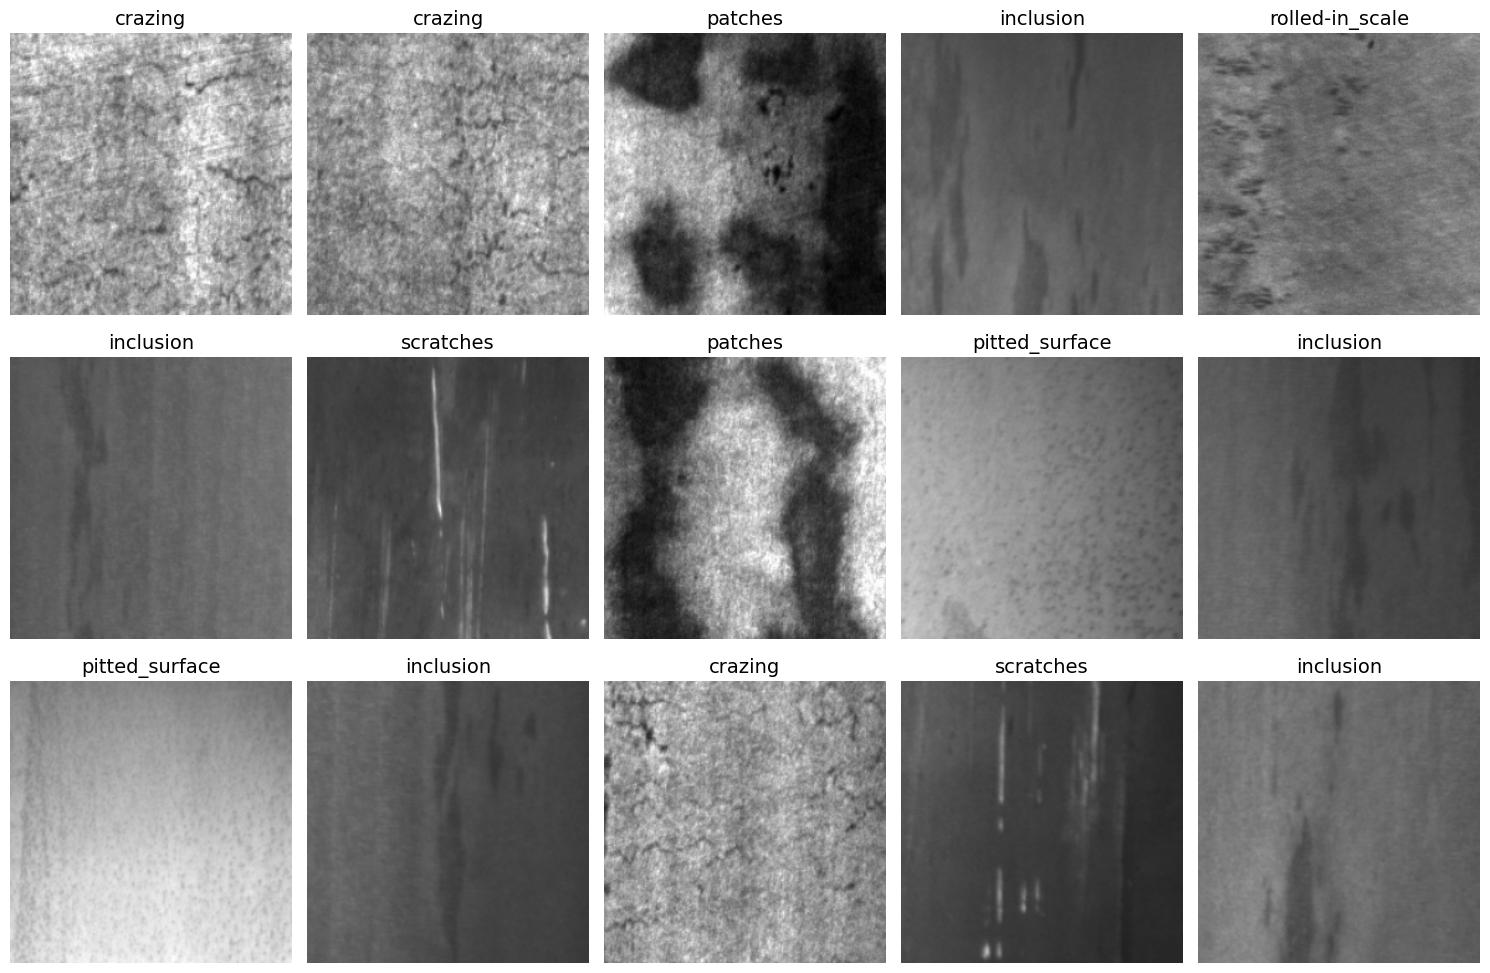

In [5]:
# Visualize sample images from dataset
for images, labels in train_dataset.take(1):
    print(f"Image shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels [:1].numpy()}")

# Display 15 sample images
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(15, len(images))):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = int(np.argmax(labels[i].numpy()))
        plt.title(class_names[label_idx], fontsize=14)
        plt.axis('off')
plt.tight_layout()
plt.show()

## 

## Transfer Leaning with MobilNetV2

In [31]:
# Load pre-trained MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,  # Remove the top classification layers
    weights='imagenet'  # Pre-trained on ImageNet
)

# Freeze base model weights - we won't update these during training
base_model.trainable = False

print(f"Base model loaded with {base_model.count_params():,} parameters")
print(f"Frozen layers: {len(base_model.layers)}")

Base model loaded with 2,257,984 parameters
Frozen layers: 154


In [32]:
# Build Transfer Learning Model
def build_transfer_learning_model():
    """Build MobileNetV2 transfer learning model for defect classification"""
    
    # Input layer and Resize to MobileNetV2 input size (224x224)
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = keras.layers.Resizing(224, 224)(inputs)
    
    # Apply MobileNetV2 preprocessing and Pass through frozen base model
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    
    # Add other layes
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
tl_model = build_transfer_learning_model()

# Compile with appropriate loss for categorical labels
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer Learning Model Summary:")
tl_model.summary()


Transfer Learning Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_3 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the Transfer Learning Model
EPOCHS = 5

print("Training Transfer Learning Model...")
tl_history = tl_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("\nTraining completed!")

Training Transfer Learning Model...
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9146 - loss: 0.2524 - val_accuracy: 0.9889 - val_loss: 0.0365
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.9972 - val_loss: 0.0139
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9965 - loss: 0.0149 - val_accuracy: 0.9972 - val_loss: 0.0128
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9972 - loss: 0.0124 - val_accuracy: 0.9972 - val_loss: 0.0147
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9944 - val_loss: 0.0116

Training completed!


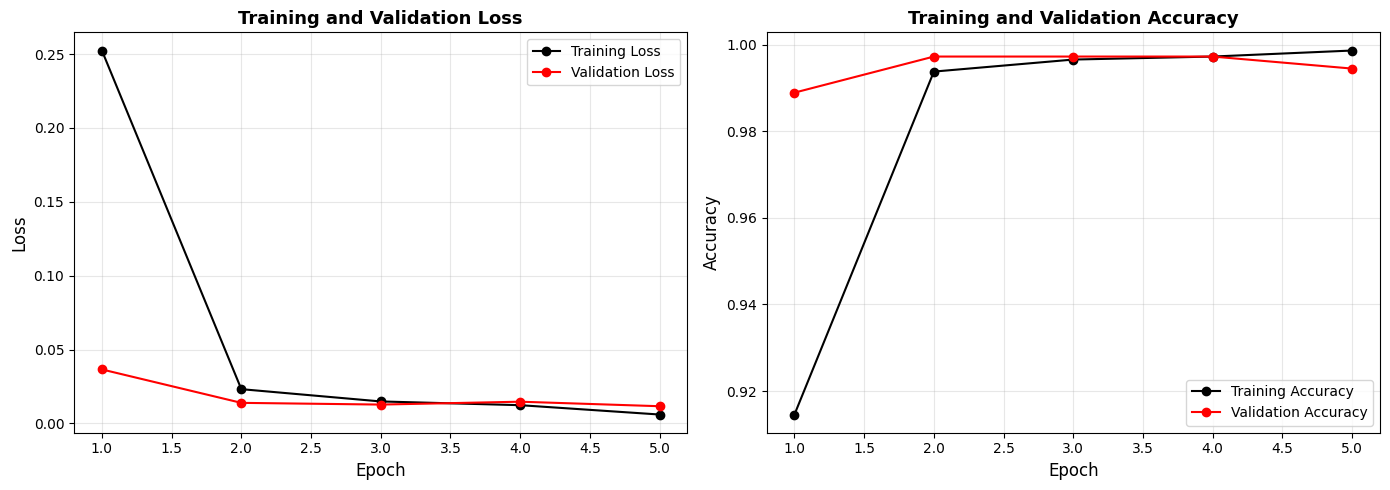

In [ ]:
# Plot Training History - Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(np.arange(1, EPOCHS + 1), tl_history.history['loss'], 
             color='black', label='Training Loss', marker='o')
axes[0].plot(np.arange(1, EPOCHS + 1), tl_history.history['val_loss'], 
             color='red', label='Validation Loss', marker='o')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(np.arange(1, EPOCHS + 1), tl_history.history['accuracy'], 
             color='black', label='Training Accuracy', marker='o')
axes[1].plot(np.arange(1, EPOCHS + 1), tl_history.history['val_accuracy'], 
             color='red', label='Validation Accuracy', marker='o')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2026-02-20 17:30:46.902329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


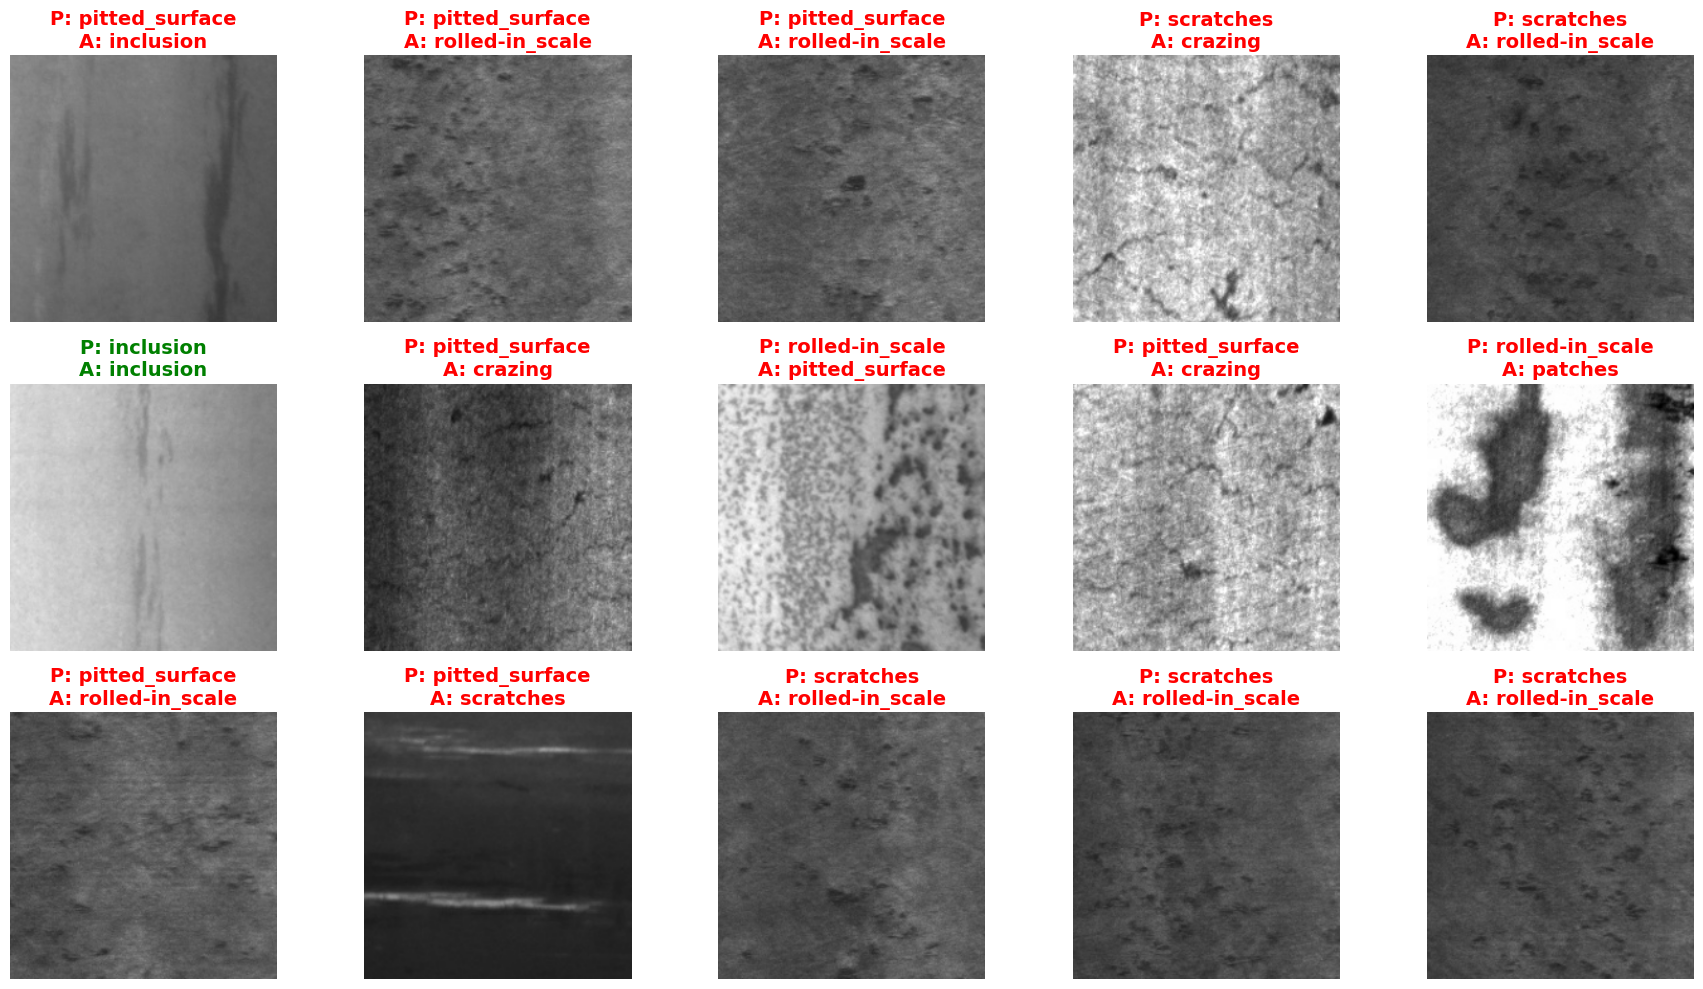

In [33]:
# Visualize Predictions on Validation Set
plt.figure(figsize=(18, 10))
for images, labels in val_dataset.take(1):
    predictions = tl_model.predict(images)
    predicted_classes = [np.argmax(pred) for pred in predictions]
    
    for i in range(0, min(15, len(images))):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        actual_class_idx = np.argmax(labels[i].numpy())
        actual_class = class_names[actual_class_idx]
        predicted_class = class_names[predicted_classes[i]]
        
        # Color title green if correct, red if wrong
        color = 'green' if actual_class_idx == predicted_classes[i] else 'red'
        plt.title(f"P: {predicted_class}\nA: {actual_class}", 
                 color=color, fontweight='bold', fontsize=14)
        plt.axis('off')

plt.tight_layout()
plt.show()

Computing predictions on entire validation dataset...


2026-02-20 15:56:23.677249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


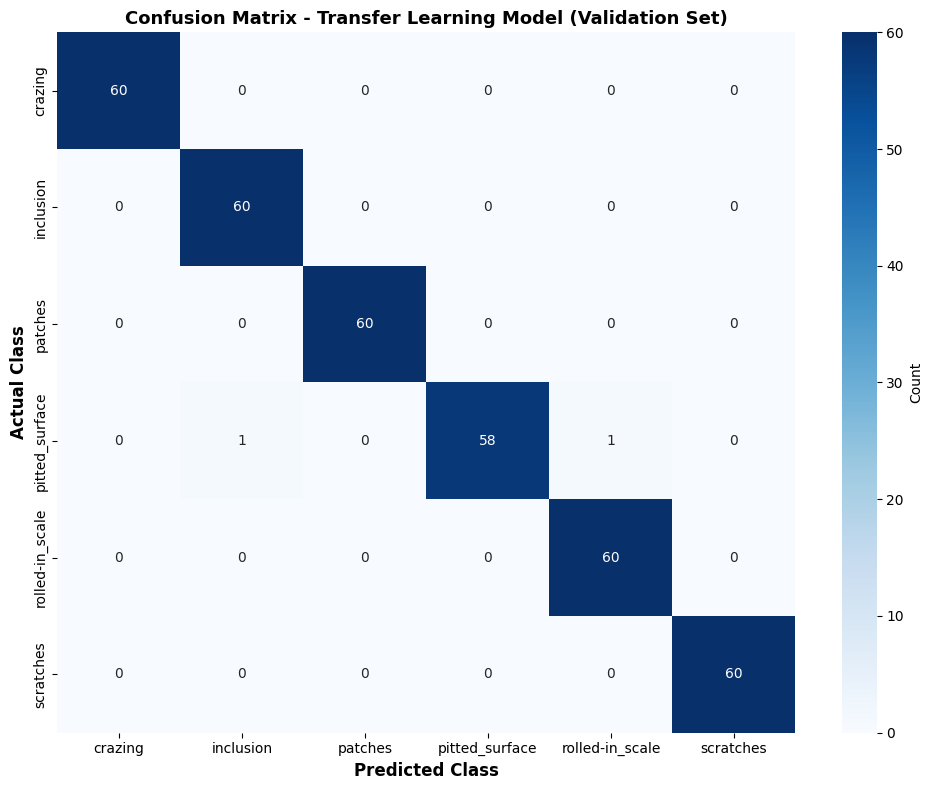


CLASSIFICATION REPORT - TRANSFER LEARNING MODEL
                 precision    recall  f1-score   support

        crazing     1.0000    1.0000    1.0000        60
      inclusion     0.9836    1.0000    0.9917        60
        patches     1.0000    1.0000    1.0000        60
 pitted_surface     1.0000    0.9667    0.9831        60
rolled-in_scale     0.9836    1.0000    0.9917        60
      scratches     1.0000    1.0000    1.0000        60

       accuracy                         0.9944       360
      macro avg     0.9945    0.9944    0.9944       360
   weighted avg     0.9945    0.9944    0.9944       360


Overall Accuracy: 99.44%


In [20]:
# Compute Confusion Matrix and Classification Report on All Validation Data
print("Computing predictions on entire validation dataset...")
tl_ypred_tot = []
tl_label_tot = []

for images, labels in val_dataset:
    predictions = tl_model.predict(images, verbose=0)
    predicted_classes = [np.argmax(pred) for pred in predictions]
    tl_ypred_tot.extend(predicted_classes)
    tl_label_tot.extend([np.argmax(label.numpy()) for label in labels])

# Create confusion matrix
tl_cm = tf.math.confusion_matrix(tl_label_tot, tl_ypred_tot, num_classes=len(class_names))

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tl_cm, annot=True, cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names, 
            fmt='d', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Transfer Learning Model (Validation Set)', 
         fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT - TRANSFER LEARNING MODEL")
print("="*60)
print(classification_report(tl_label_tot, tl_ypred_tot, 
                          labels=range(len(class_names)), 
                          target_names=class_names, 
                          digits=4))

# Print accuracy summary
overall_accuracy = np.sum(np.diag(tl_cm)) / np.sum(tl_cm)
print(f"\nOverall Accuracy: {overall_accuracy:.2%}")
print("="*60)

In [34]:
#save the model
tl_model.save("mobilenetv2_transfer_learning_model.h5")

# ResNet50 for Defect classification

![ResNet50 Architecture](images/ResNet.png)

In [19]:
# Load Resnet50 base model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
)

# Freeze base model weights - we won't update these during training
base_model.trainable = False

print(f"Base model loaded with {base_model.count_params():,} parameters")
print(f"Frozen layers: {len(base_model.layers)}")

# Print all layers with indices
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name}")

Base model loaded with 23,564,800 parameters
Frozen layers: 190
0: input_layer_6
1: conv1_pad
2: conv1_conv
3: pool1_pad
4: pool1_pool
5: conv2_block1_preact_bn
6: conv2_block1_preact_relu
7: conv2_block1_1_conv
8: conv2_block1_1_bn
9: conv2_block1_1_relu
10: conv2_block1_2_pad
11: conv2_block1_2_conv
12: conv2_block1_2_bn
13: conv2_block1_2_relu
14: conv2_block1_0_conv
15: conv2_block1_3_conv
16: conv2_block1_out
17: conv2_block2_preact_bn
18: conv2_block2_preact_relu
19: conv2_block2_1_conv
20: conv2_block2_1_bn
21: conv2_block2_1_relu
22: conv2_block2_2_pad
23: conv2_block2_2_conv
24: conv2_block2_2_bn
25: conv2_block2_2_relu
26: conv2_block2_3_conv
27: conv2_block2_out
28: conv2_block3_preact_bn
29: conv2_block3_preact_relu
30: conv2_block3_1_conv
31: conv2_block3_1_bn
32: conv2_block3_1_relu
33: conv2_block3_2_pad
34: conv2_block3_2_conv
35: conv2_block3_2_bn
36: conv2_block3_2_relu
37: max_pooling2d_6
38: conv2_block3_3_conv
39: conv2_block3_out
40: conv3_block1_preact_bn
41: con

In [13]:
# Build Transfer Learning Model with ResNet50V2
def build_transfer_learning_model_resnet50():
    """Build ResNet50V2 transfer learning model for defect classification"""
    
    # Input layer and Resize to ResNet50V2 input size (200x200)
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = keras.layers.Resizing(200, 200)(inputs)
    
    # Apply ResNet50V2 preprocessing and Pass through frozen base model
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    
    # Add other layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
resnet_model = build_transfer_learning_model_resnet50()

# Compile with appropriate loss for categorical labels
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTransfer Learning Model Summary (ResNet50V2):")
resnet_model.summary()

# Train the ResNet Transfer Learning Model
RESNET_EPOCHS = 10

print("Training ResNet50V2 Transfer Learning Model...")
resnet_history = resnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=RESNET_EPOCHS,
    verbose=1
)


resnet_model.save("resnet50v2_model.h5")
print("\nTraining completed!")


Transfer Learning Model Summary (ResNet50V2):


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,886 (91.90 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Training ResNet50V2 Transfer Learning Model...
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8806 - loss: 0.3702 - val_accuracy: 0.9444 - val_loss: 0.1768
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9875 - loss: 0.0496 - val_accuracy: 0.9917 - val_loss: 0.0422
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9937 - loss: 0.0303 - val_accuracy: 0.9806 - val_loss: 0.0547
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9951 - loss: 0.0187 - val_accuracy: 0.9861 - val_loss: 0.0361
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9993 - loss: 0.0096 - val_accuracy: 0.9833 - val_loss: 0.0455
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9972 - loss: 0.0107 - val_accuracy: 0.9750 - val_loss: 0.0570
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9979 - loss: 0.0093 - val_accuracy: 0.9833 - val_loss: 0.0433
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9965 

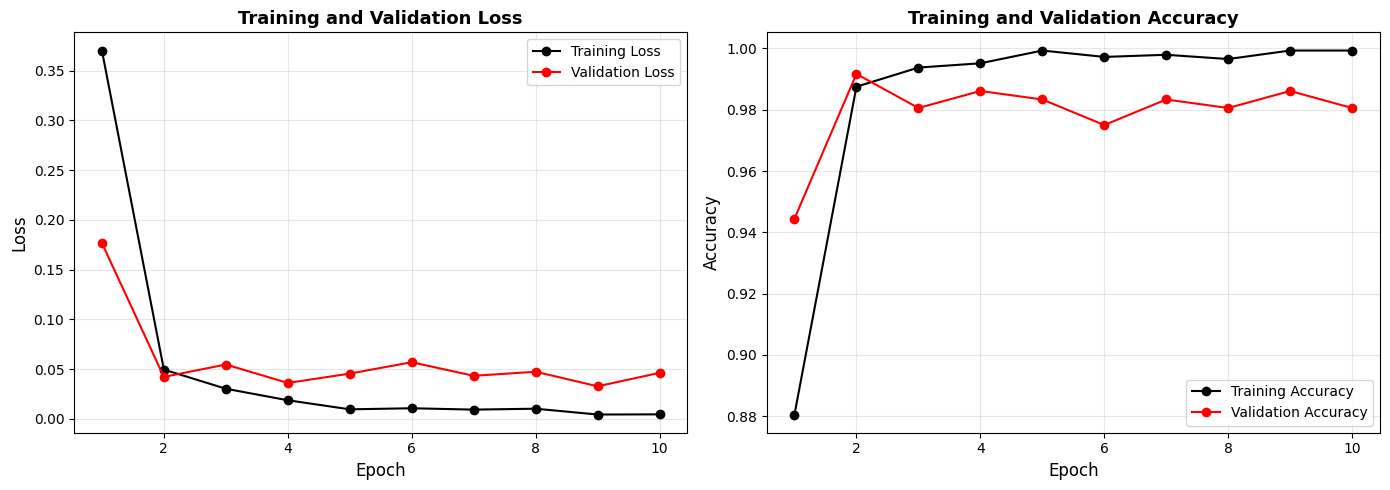

In [16]:
# Plot Training History - Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(np.arange(1, RESNET_EPOCHS + 1), resnet_history.history['loss'], 
             color='black', label='Training Loss', marker='o')
axes[0].plot(np.arange(1, RESNET_EPOCHS + 1), resnet_history.history['val_loss'], 
             color='red', label='Validation Loss', marker='o')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(np.arange(1, RESNET_EPOCHS + 1), resnet_history.history['accuracy'], 
             color='black', label='Training Accuracy', marker='o')
axes[1].plot(np.arange(1, RESNET_EPOCHS + 1), resnet_history.history['val_accuracy'], 
             color='red', label='Validation Accuracy', marker='o')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2026-02-21 15:16:32.219971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


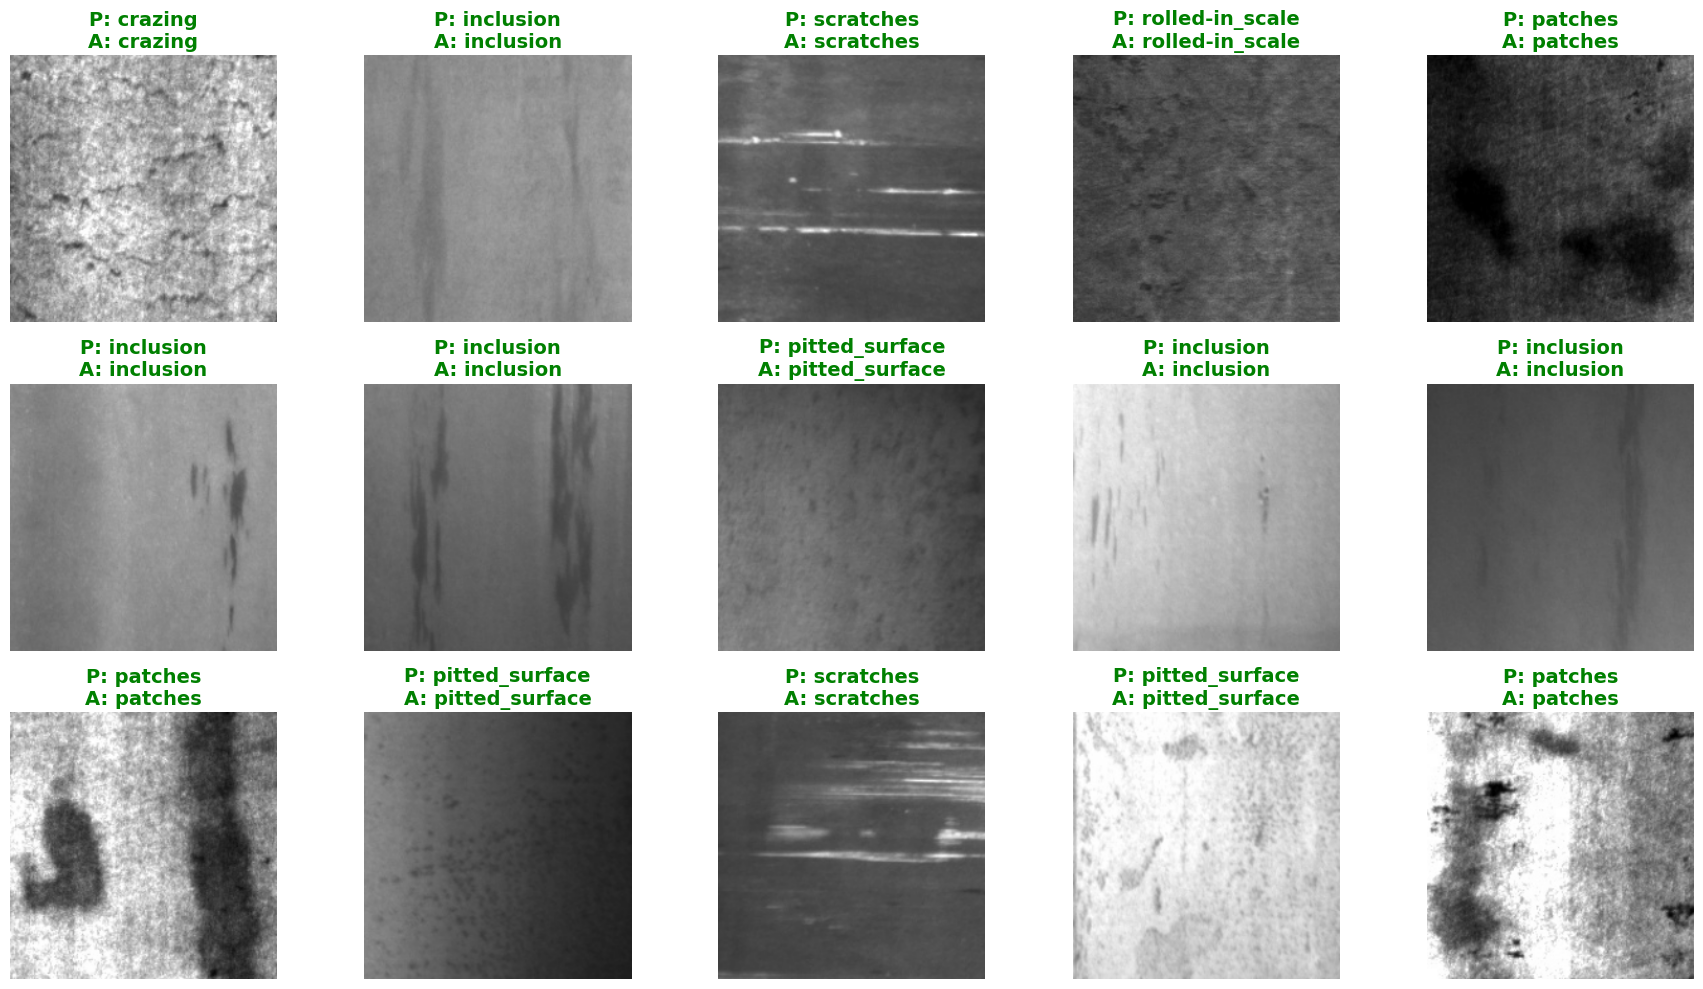

In [18]:
# Visualize Predictions on Validation Set
plt.figure(figsize=(18, 10))
for images, labels in val_dataset.take(1):
    predictions = resnet_model.predict(images)
    predicted_classes = [np.argmax(pred) for pred in predictions]
    
    for i in range(0, min(15, len(images))):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        actual_class_idx = np.argmax(labels[i].numpy())
        actual_class = class_names[actual_class_idx]
        predicted_class = class_names[predicted_classes[i]]
        
        # Color title green if correct, red if wrong
        color = 'green' if actual_class_idx == predicted_classes[i] else 'red'
        plt.title(f"P: {predicted_class}\nA: {actual_class}", 
                 color=color, fontweight='bold', fontsize=14)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Fine-tune ResNet50V2 - Unfreeze deeper layers for task-specific learning

# Unfreeze base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
resnet_finetune = resnet_model
resnet_finetune.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for more epochs
FINETUNE_EPOCHS = 5
print(f"Fine-tuning ResNet50V2 for {FINETUNE_EPOCHS} epochs...")
resnet_ft_history = resnet_finetune.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=FINETUNE_EPOCHS,
    verbose=1
)

resnet_finetune.save("resnet50v2_finetuned_model.h5")
print("Fine-tuned model saved!")

Fine-tuning ResNet50V2 for 5 epochs...
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9861 - val_loss: 0.0391
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9861 - val_loss: 0.0365
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9861 - val_loss: 0.0350
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9861 - val_loss: 0.0342
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9861 - val_loss: 0.0331


Fine-tuning ResNet50V2 for 5 epochs...
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9861 - val_loss: 0.0391
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9861 - val_loss: 0.0365
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9861 - val_loss: 0.0350
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9861 - val_loss: 0.0342
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9861 - val_loss: 0.0331


Fine-tuning ResNet50V2 for 5 epochs...
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9861 - val_loss: 0.0391
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9861 - val_loss: 0.0365
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9861 - val_loss: 0.0350
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9861 - val_loss: 0.0342
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9861 - val_loss: 0.0331


Fine-tuned model saved!


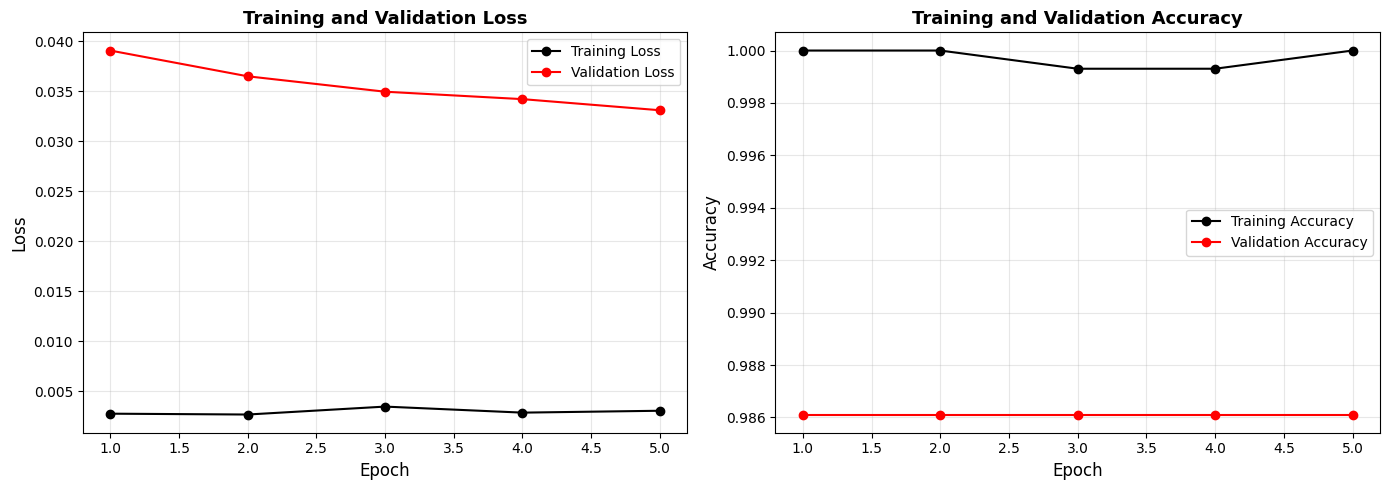

In [22]:
# Plot Training History - Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(np.arange(1, FINETUNE_EPOCHS + 1), resnet_ft_history.history['loss'], 
             color='black', label='Training Loss', marker='o')
axes[0].plot(np.arange(1, FINETUNE_EPOCHS + 1), resnet_ft_history.history['val_loss'], 
             color='red', label='Validation Loss', marker='o')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(np.arange(1, FINETUNE_EPOCHS + 1), resnet_ft_history.history['accuracy'], 
             color='black', label='Training Accuracy', marker='o')
axes[1].plot(np.arange(1, FINETUNE_EPOCHS + 1), resnet_ft_history.history['val_accuracy'], 
             color='red', label='Validation Accuracy', marker='o')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Vision Transformer (ViT) for Defect Classification

Vision Transformers use self-attention mechanisms instead of convolutions, allowing the model to capture global spatial relationships in images.

![Vision Transformer Architecture](images/Vit.png)

In [ ]:
# CUSTOM VISION TRANSFORMER (TRAINING FROM SCRATCH) 

# Define Patch Embedding layer for Vision Transformer
class PatchEmbedding(layers.Layer):
    """Convert image into patches and embed them"""
    def __init__(self, patch_size=16, embed_dim=128):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Use Conv2D for efficient patch extraction
        self.projection = layers.Conv2D(
            embed_dim, 
            kernel_size=patch_size, 
            strides=patch_size,
            padding='valid'
        )
        self.flatten = layers.Reshape((-1, embed_dim))

    def call(self, x):
        # Project patches to embedding dimension
        x = self.projection(x)
        # Flatten to (batch_size, num_patches, embed_dim)
        x = self.flatten(x)
        return x

# Define Transformer Block
class TransformerBlock(layers.Layer):
    """Transformer block with multi-head attention and MLP"""
    def __init__(self, embed_dim=128, num_heads=4, mlp_dim=256, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        
        # Multi-head attention
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim,
            dropout=dropout_rate
        )
        
        # MLP block
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation=tf.nn.gelu),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
            layers.Dropout(dropout_rate),
        ])
        
        # Layer normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training=None):
        # Self-attention block with residual connection
        attn_output = self.attention(x, x, dropout_mask=None, training=training)
        attn_output = self.dropout(attn_output, training=training)
        x = self.layernorm1(x + attn_output)
        
        # MLP block with residual connection
        mlp_output = self.mlp(x, training=training)
        x = self.layernorm2(x + mlp_output)
        
        return x

# Build Vision Transformer Model (from scratch)
def build_vit_model_scratch(input_shape, num_classes, patch_size=16, num_layers=4, 
                             num_heads=4, embed_dim=128, mlp_dim=256, dropout_rate=0.1):
    """Build Vision Transformer model for image classification (trained from scratch)"""
    
    inputs = layers.Input(shape=input_shape)
    
    # Create patches and embed them
    x = PatchEmbedding(patch_size=patch_size, embed_dim=embed_dim)(inputs)
    
    # Add positional embeddings
    num_patches = (input_shape[0] // patch_size) ** 2
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = pos_embedding(positions)
    x = x + position_embedding
    
    # Apply transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, mlp_dim, dropout_rate)(x)
    
    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)  # Average over all patches
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build the ViT model (from scratch)
print("Building Vision Transformer Model (from scratch)...")
vit_model_scratch = build_vit_model_scratch(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    num_classes=len(class_names),
    patch_size=16,
    num_layers=4,
    num_heads=4,
    embed_dim=128,
    mlp_dim=256,
    dropout_rate=0.1
)

# Compile the model
vit_model_scratch.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nVision Transformer Model (from scratch) Summary:")
vit_model_scratch.summary()

In [ ]:
# VISION TRANSFORMER WITH TRANSFER LEARNING 
# Install keras_cv for pretrained Vision Transformer
import subprocess
import sys

try:
    import keras_cv
except ImportError:
    print("Installing keras_cv...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "keras_cv"])
    import keras_cv

# Build Transfer Learning Model with Vision Transformer
def build_vit_transfer_learning_model():
    """Build Vision Transformer transfer learning model for defect classification"""
    
    # Input layer and Resize to ViT input size (224x224)
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = keras.layers.Resizing(224, 224)(inputs)
    
    # Load pretrained ViT model from keras_cv
    # ViT base model trained on ImageNet21k and fine-tuned on ImageNet1k
    base_model = keras_cv.models.ViT(
        include_top=False,
        input_shape=(224, 224, 3),
        weights="imagenet"
    )
    
    # Freeze base model weights - we won't update these during training
    base_model.trainable = False
    
    # Pass input through base model
    x = base_model(x, training=False)
    
    # Add classification head
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(len(class_names), activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model, base_model

# Build the ViT transfer learning model
print("Building Vision Transformer Transfer Learning Model...")
print("Loading pretrained ViT from ImageNet weights...")
vit_model_transfer, vit_base_model = build_vit_transfer_learning_model()

print(f"Base model loaded with {vit_base_model.count_params():,} parameters")
print(f"Frozen layers: {len(vit_base_model.layers)}")

# Compile the model
vit_model_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nVision Transformer Transfer Learning Model Summary:")
vit_model_transfer.summary()

In [ ]:
# Train Vision Transformer Model (from scratch)
VIT_EPOCHS = 10

print("="*60)
print("Training Vision Transformer Model (FROM SCRATCH)...")
print("="*60)
vit_history_scratch = vit_model_scratch.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=VIT_EPOCHS,
    verbose=1
)

print("\nTraining completed!")
vit_model_scratch.save("vit_model_scratch.h5")

In [ ]:
# Train Vision Transformer Model (Transfer Learning)
VIT_EPOCHS = 10

print("="*60)
print("Training Vision Transformer Model (TRANSFER LEARNING)...")
print("="*60)
vit_history_transfer = vit_model_transfer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=VIT_EPOCHS,
    verbose=1
)

print("\nTraining completed!")
vit_model_transfer.save("vit_model_transfer.h5")

In [ ]:
# Plot Vision Transformer Training History (FROM SCRATCH)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(np.arange(1, VIT_EPOCHS + 1), vit_history_scratch.history['loss'], 
             color='black', label='Training Loss', marker='o')
axes[0].plot(np.arange(1, VIT_EPOCHS + 1), vit_history_scratch.history['val_loss'], 
             color='red', label='Validation Loss', marker='o')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Vision Transformer (From Scratch) - Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(np.arange(1, VIT_EPOCHS + 1), vit_history_scratch.history['accuracy'], 
             color='black', label='Training Accuracy', marker='o')
axes[1].plot(np.arange(1, VIT_EPOCHS + 1), vit_history_scratch.history['val_accuracy'], 
             color='red', label='Validation Accuracy', marker='o')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Vision Transformer (From Scratch) - Training and Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot Vision Transformer Training History (TRANSFER LEARNING)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(np.arange(1, VIT_EPOCHS + 1), vit_history_transfer.history['loss'], 
             color='black', label='Training Loss', marker='o')
axes[0].plot(np.arange(1, VIT_EPOCHS + 1), vit_history_transfer.history['val_loss'], 
             color='red', label='Validation Loss', marker='o')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Vision Transformer (Transfer Learning) - Training and Validation Loss', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Visualize Vision Transformer Predictions on Validation Set
plt.figure(figsize=(18, 10))
for images, labels in val_dataset.take(1):
    predictions = vit_model.predict(images)
    predicted_classes = [np.argmax(pred) for pred in predictions]
    
    for i in range(0, min(15, len(images))):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        actual_class_idx = np.argmax(labels[i].numpy())
        actual_class = class_names[actual_class_idx]
        predicted_class = class_names[predicted_classes[i]]
        
        # Color title green if correct, red if wrong
        color = 'green' if actual_class_idx == predicted_classes[i] else 'red'
        plt.title(f"P: {predicted_class}\nA: {actual_class}", 
                 color=color, fontweight='bold', fontsize=14)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Compute Confusion Matrix and Classification Report for Vision Transformer
print("Computing predictions on entire validation dataset...")
vit_ypred_tot = []
vit_label_tot = []

for images, labels in val_dataset:
    predictions = vit_model.predict(images, verbose=0)
    predicted_classes = [np.argmax(pred) for pred in predictions]
    vit_ypred_tot.extend(predicted_classes)
    vit_label_tot.extend([np.argmax(label.numpy()) for label in labels])

# Create confusion matrix
vit_cm = tf.math.confusion_matrix(vit_label_tot, vit_ypred_tot, num_classes=len(class_names))

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(vit_cm, annot=True, cmap="Greens", 
            xticklabels=class_names, yticklabels=class_names, 
            fmt='d', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Vision Transformer (Validation Set)', 
         fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT - VISION TRANSFORMER MODEL")
print("="*60)
print(classification_report(vit_label_tot, vit_ypred_tot, 
                          labels=range(len(class_names)), 
                          target_names=class_names, 
                          digits=4))

# Print accuracy summary
overall_accuracy = np.sum(np.diag(vit_cm)) / np.sum(vit_cm)
print(f"\nOverall Accuracy: {overall_accuracy:.2%}")
print("="*60)"